In [1]:
import pynbody
import numpy as np

In [2]:
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

### Some ugly code for reading in the particles...

In [3]:
def make_batches(n_parts, n_batches): 
    batch_size = n_parts/n_batches
    curr_start = 0
    while curr_start < n_parts:
        yield((curr_start, min(curr_start+batch_size, n_parts+1)))
        curr_start += batch_size

In [4]:
from pyspark.sql import Row
from pynbody import util, units, family
from pyspark.sql.types import ArrayType, DoubleType, FloatType, NullType, StructType, StructField, StringType, ByteType

class SparkTipsySnap(pynbody.tipsy.TipsySnap) :
    
    def _load_main_file(self):
        #logger.info("Loading data from main file %s", self._filename)

        f = util.open_(self._filename, 'rb')
        f.seek(32)

        max_item_size = max(
            [q.itemsize for q in self._g_dtype, self._d_dtype, self._s_dtype])
        tbuf = bytearray(max_item_size * 10240)

        for fam, dtype in ((family.gas, self._g_dtype), (family.dm, self._d_dtype), (family.star, self._s_dtype)):
            self_fam = self[fam]
            st_len = dtype.itemsize
            for readlen, buf_index, mem_index in self._load_control.iterate([fam], [fam], multiskip=True):
                # Read in the block
                if mem_index is None:
                    f.seek(st_len * readlen, 1)
                    continue

                buf = np.fromstring(f.read(st_len * readlen), dtype=dtype)
                
                if self._byteswap:
                    buf = buf.byteswap()
                
                yield buf, buf_index, fam
                
    
fam_lookup = {family.dm:'d', family.gas: 'g', family.star:'s'}

def buf_to_row(buf, buf_index, names, fam) : 
    if type(buf_index) == slice:
        buf_index = xrange(buf_index.start, buf_index.stop)
    for i in buf_index :
        d = {name:float(buf[name][i]) for name in buf.dtype.names} # this should be an OrderedDict
        for name in names: 
            if name not in d: 
                d[name] = np.nan
                d['fam'] = fam_lookup[fam]
        yield Row(**d)                

In [5]:
def load_partition(filename, batch_iter, names) : 
    for batch in batch_iter :
        s = SparkTipsySnap(filename, take = xrange(*batch))
        loader = s._load_main_file()
        for buf, bi, fam in loader : 
            for row in buf_to_row(buf, bi, names, fam) : 
                yield row
            del(buf)
        del(s)

### Data read and conversion to `DataFrame`

In [6]:
filename = '/cluster/home03/sdid/roskarr/work/testing/cosmo25cmb.768g2_dm.001024'
s = pynbody.load(filename)

In [7]:
names = set(s._g_dtype.names) | set(s._s_dtype.names) | set(s._d_dtype.names)

In [8]:
n_parts = len(s)

In [9]:
batches = make_batches(n_parts, 800-1)

In [10]:
batches_rdd = sc.parallelize(batches, 800)

In [11]:
#sc.addPyFile('/cluster/home03/sdid/roskarr/src/pynbody/dist/pynbody-0.31-py2.7-linux-x86_64.egg')

In [12]:
sim_rdd = batches_rdd.mapPartitions(lambda iterator: load_partition(filename, iterator, names))

In [13]:
schema = StructType(fields = [StructField('eps', FloatType(), True), 
                               StructField('fam', StringType(), True),
                               StructField('mass', FloatType(), True),
                               StructField('metals', FloatType(), True),
                               StructField('phi', FloatType(), True),
                              StructField('rho', FloatType(), True),
                              StructField('temp', FloatType(), True),
                              StructField('tform', FloatType(), True),
                              StructField('vx', FloatType(), True),
                              StructField('vy', FloatType(), True),
                              StructField('vz', FloatType(), True),
                              StructField('x', FloatType(), True),
                              StructField('y', FloatType(), True),
                              StructField('z', FloatType(), True),])

In [14]:
df = sim_rdd.toDF(schema)

In [15]:
df.select('mass', 'x', 'y', 'z').show()

+-------------+-----------+-----------+----------+
|         mass|          x|          y|         z|
+-------------+-----------+-----------+----------+
|1.0154857E-10|-0.41583994|-0.42880762| 0.4220333|
|1.0154857E-10| -0.4170401| -0.4275199|0.42231753|
|1.0154857E-10|-0.41655722|-0.42766565| 0.4223259|
|1.0154857E-10|-0.41671997|-0.42697328| 0.4228194|
|1.0154857E-10| -0.4170576|-0.42447266| 0.4226917|
|1.0154857E-10|-0.41692457| -0.4255475|0.42324886|
|1.0154857E-10|-0.41573152| -0.4264287|0.42298603|
|1.0154857E-10|-0.41570926|-0.42558408|0.42263356|
|1.0154857E-10|-0.41670665|-0.42773277| 0.4234212|
|1.0154857E-10| -0.4164624|-0.42720002| 0.4232937|
|1.0154857E-10|-0.41709548|-0.42287406|0.42332387|
|1.0154857E-10|-0.41609466|-0.42538744|0.42336327|
|1.0154857E-10|-0.41849965|-0.42489263|0.42386532|
|1.0154857E-10|-0.41691625|-0.42734033|0.42359728|
|1.0154857E-10|-0.41441837|-0.43146068|0.42128232|
|1.0154857E-10|-0.41666746|-0.42466545|0.42309728|
|1.0154857E-10|-0.41687754| -0.

In [16]:
df.cache().count()

1981808640

In [17]:
df.write.mode('overwrite').parquet('/user/roskarr/nbody/cosmo25cmb.768g2_dm/cosmo25cmb.768g2_dm.001024.parquet')

In [39]:
df.unpersist()
del(df)

### Reading in the full dataset from a distributed parquet file

Reading in from parquet is now much faster because we don't have to convert and format the data... 

In [5]:
sqc = SQLContext(sc)

In [12]:
%%time
df = sqc.read.parquet('/user/roskarr/nbody/cosmo25cmb.768g2_dm/cosmo25cmb.768g2_dm.001024.parquet')
df.cache().count()

CPU times: user 6 ms, sys: 5 ms, total: 11 ms
Wall time: 32.4 s


In [13]:
df.printSchema()

root
 |-- eps: float (nullable = true)
 |-- fam: string (nullable = true)
 |-- mass: float (nullable = true)
 |-- metals: float (nullable = true)
 |-- phi: float (nullable = true)
 |-- rho: float (nullable = true)
 |-- temp: float (nullable = true)
 |-- tform: float (nullable = true)
 |-- vx: float (nullable = true)
 |-- vy: float (nullable = true)
 |-- vz: float (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- z: float (nullable = true)



In [14]:
%time df.count()

CPU times: user 999 µs, sys: 1 ms, total: 2 ms
Wall time: 2.61 s


1981808640

### Sub-sampling for visualization

To visualize the data, it must be brought to the driver and therefore sub-sampled. 

In [15]:
sampled = df.select('x','y','z').sample(False, 0.0001, 1).toPandas()

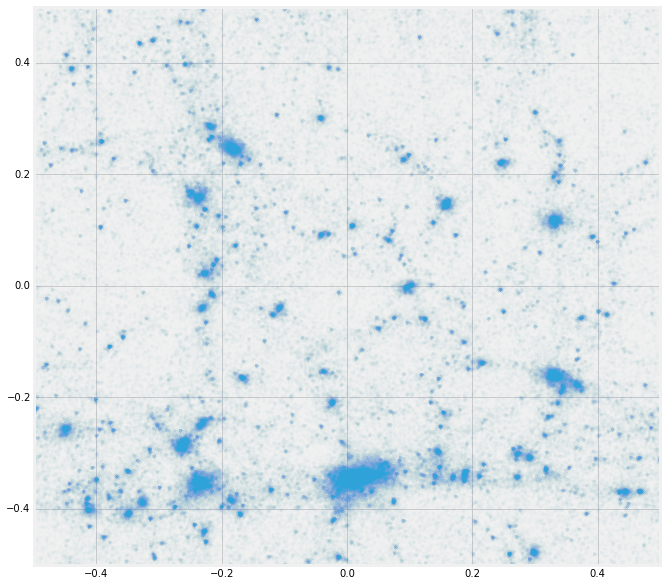

In [16]:
plt.figure(figsize=(10,10))
plt.plot(sampled['x'], sampled['y'], '.', alpha = .02)
plt.xlim(-.5,.5); plt.ylim(-.5,.5);

### Creating a filtered dataset 

Lets say we want to focus on the big blob around `x = 0` and `y = 0.3`:

In [17]:
filt_string = 'abs(x)< cast(.1 as float) and y < cast(-.2 as float) and y > cast(-.4 as float)'

In [18]:
%%time
filtered = df.filter(filt_string)
print '%e'%filtered.count()

3.174341e+08
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 3.26 s


In [19]:
sampled = filtered.select('x','y').sample(False, 0.001, 1).toPandas()

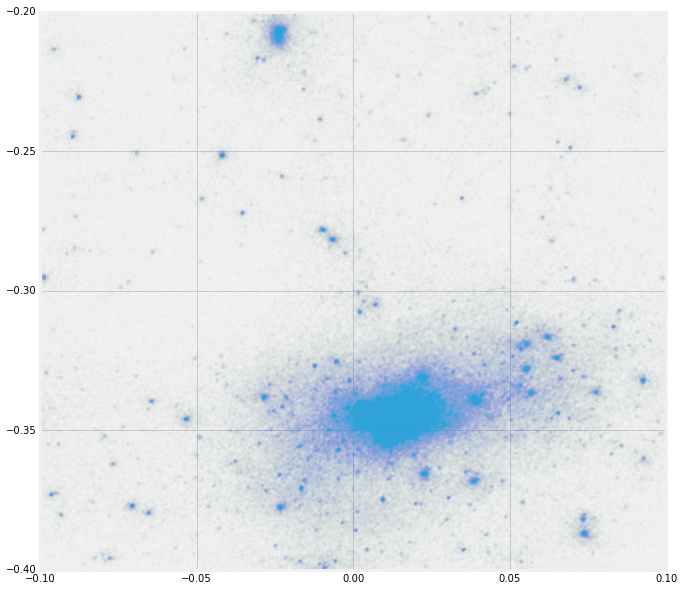

In [20]:
plt.figure(figsize=(10,10))
plt.plot(sampled['x'], sampled['y'], '.', alpha = .01)

In [21]:
from pyspark.mllib.clustering import KMeans

In [22]:
points = filtered.select('x', 'y', 'z', 'vx', 'vy', 'vz').rdd.map(lambda r: np.array(r))

In [23]:
points.cache().count()

317434141

### Data read using filtering at the source

Because each parquet file keeps metadata about data ranges of each column, many files can be completely skipped in some cases, resulting in much more efficient data-ingestion. 

In [32]:
df2 = sqc.read.parquet('/user/roskarr/nbody/cosmo25cmb.768g2_dm/cosmo25cmb.768g2_dm.001024.parquet')
filtered2 = df2.filter(filt_string)

In [33]:
filtered2.explain()

Filter (((abs(x#1185) < 0.1) && (y#1186 < -0.2)) && (y#1186 > -0.4))
 InMemoryColumnarTableScan [eps#1174,fam#1175,mass#1176,metals#1177,phi#1178,rho#1179,temp#1180,tform#1181,vx#1182,vy#1183,vz#1184,x#1185,y#1186,z#1187], [(abs(x#1185) < 0.1),(y#1186 < -0.2),(y#1186 > -0.4)], (InMemoryRelation [eps#1174,fam#1175,mass#1176,metals#1177,phi#1178,rho#1179,temp#1180,tform#1181,vx#1182,vy#1183,vz#1184,x#1185,y#1186,z#1187], true, 10000, StorageLevel(true, true, false, true, 1), (Scan ParquetRelation[hdfs://hadoop.ethz.ch:8020/user/roskarr/nbody/cosmo25cmb.768g2_dm/cosmo25cmb.768g2_dm.001024.parquet][eps#337,fam#338,mass#339,metals#340,phi#341,rho#342,temp#343,tform#344,vx#345,vy#346,vz#347,x#348,y#349,z#350]), None)



In [34]:
%%time
filtered2.count()

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 2.43 s


317434141

Note that this is faster than what was done above, i.e. filtering the full cached dataset. In the previous case, every element of the dataset still needed to be touched, whereas in this case large chunks of the data were automatically excluded completely. 

In [36]:
points = filtered2.select('x', 'y', 'z', 'vx', 'vy', 'vz').rdd.map(lambda r: np.array(r))
points.cache().count()

317434141

### Training a model on the data

For fun, lets train a K-Means model on the position and velocity data in the filtered area.

In [37]:
model = KMeans.train(points, 100)

In [38]:
cluster_rdd = (points.sample(False, 0.1, 1)
                     .map(lambda vec: (model.predict(vec),vec))
                     .filter(lambda (cluster, vec): cluster < 10))

In [39]:
cluster_subsample = cluster_rdd.takeSample(False, 100000, 1)

In [40]:
colors = [u'#a6cee3', u'#1f78b4', u'#b2df8a', u'#33a02c', u'#fb9a99', u'#e31a1c', u'#fdbf6f', u'#ff7f00', u'#cab2d6', u'#6a3d9a']

In [42]:
from matplotlib.colors import ColorConverter

cc = ColorConverter()

colors_k100 = [cc.to_rgba(colors[cluster]) for (cluster, vec) in cluster_subsample]

In [43]:
vecs = np.vstack((vec for (cluster,vec) in cluster_subsample))

In [64]:
plt.rcParams['font.size'] = 18

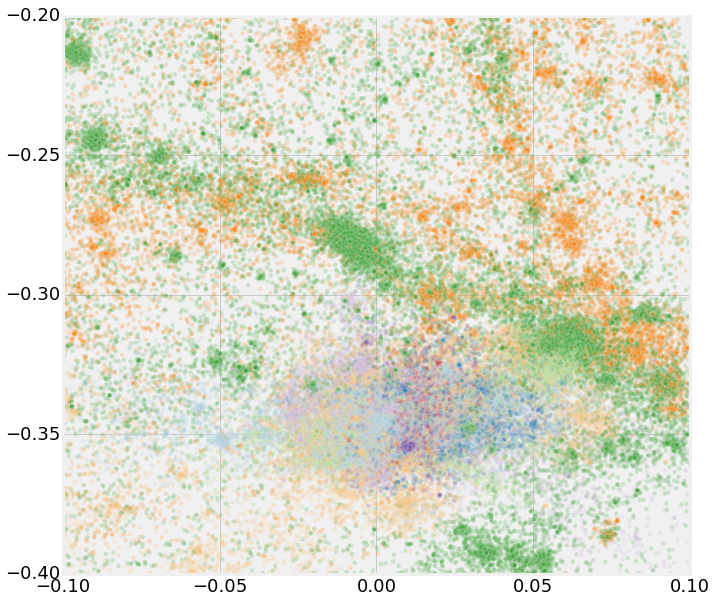

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(vecs[:,0], vecs[:,1], c= colors_k100, alpha=0.2)
plt.xlim(-.1,.1); plt.ylim(-.4,-.2);